In [18]:
import numpy as np

from PIL import Image, ImageFilter
from matplotlib import pylab as pylab
from matplotlib import pyplot as plt

from scipy.fft import dct, idct
from scipy.signal.windows import kaiser_bessel_derived as kbdw

# %matplotlib inline
pylab.rcParams['figure.figsize'] = (8, 8)

from pathlib import Path

image = 'wood'
size  = 2048

experiment = '3lap'

output = Path('outputs') / f'{image}-{size}'

output.mkdir(exist_ok=True, parents=True)

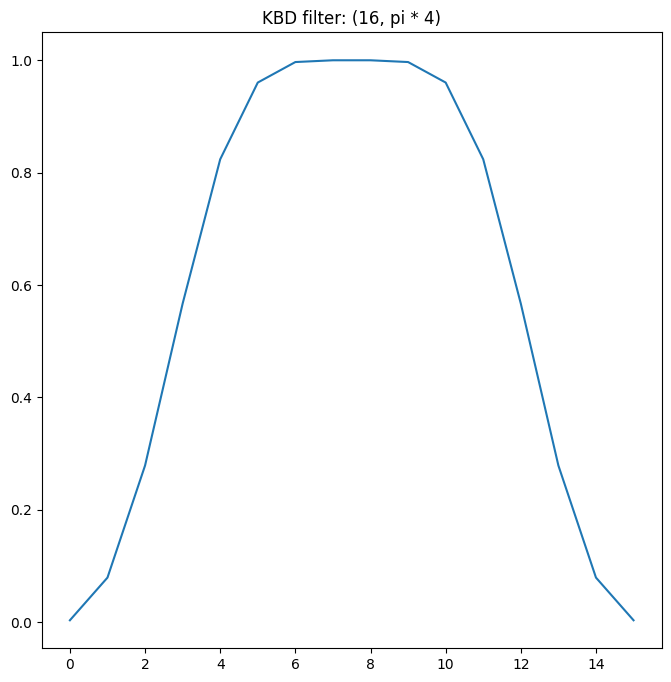

In [19]:
N=16

dct_type = 4
dct_norm = 'ortho'
kbd_alpha = 4.0
kbd_alpha = 4

wfltr = kbdw(N, np.pi * kbd_alpha) # upto 709

plt.figure()
plt.plot(wfltr)
plt.title(f"KBD filter: (16, pi * {kbd_alpha})")

plt.savefig(f'{output}/kbd.png')

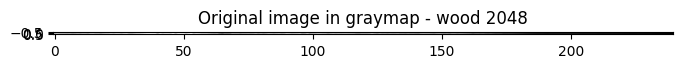

In [20]:
y, cb, cr = Image.open(f'../../images/{image}/{image}-{size}.png').convert('YCbCr').split()

im = np.array(y)
im = im[:im.shape[0] - im.shape[0]%8, :im.shape[1] - im.shape[1]%8]

im = im.astype(np.int64)

im = np.asmatrix(im[0][:240])

plt.figure()
plt.imshow(im, cmap='gray')
plt.title(f"Original image in graymap - {image} {size}")

plt.imsave(f'{output}/original.png', im, cmap='gray')

In [21]:
def mdct(x):
    N = x.shape[0]

    if N%4 != 0:
        raise ValueError("MDCT4 only defined for vectors of length multiple of four.")

    N4 = N // 4

    a = x[0*N4:1*N4]
    b = x[1*N4:2*N4]
    c = x[2*N4:3*N4]
    d = x[3*N4:4*N4]

    br = np.flip(b)
    cr = np.flip(c)

    return dct(np.hstack([-cr - d, a - br]), type=4, norm='ortho', orthogonalize=True) / 2


def imdct(y):
    N = y.shape[0] * 2

    if N%4 != 0:
        raise ValueError("IMDCT is only defined for vectors lengths multiple of two.")
    
    N4 = N // 4

    z = idct(y, type=4, norm='ortho', orthogonalize=True)

    z = np.hstack([z, -np.flip(z), -z]) * 2

    return z[N4:5*N//4]


def mdct4(x):
    N = x.shape[0]
    if N%4 != 0:
        raise ValueError("MDCT4 only defined for vectors of length multiple of four.")
    M = N // 2
    N4 = N // 4
    
    rot = np.roll(x, N4)
    rot[:N4] = -rot[:N4]
    t = np.arange(0, N4)
    w = np.exp(-1j*2*np.pi*(t + 1./8.) / N)
    c = np.take(rot,2*t) - np.take(rot, N-2*t-1) \
        - 1j * (np.take(rot, M+2*t) - np.take(rot,M-2*t-1))
    c = (2./np.sqrt(N)) * w * np.fft.fft(0.5 * c * w, N4)
    y = np.zeros(M)
    y[2*t] = np.real(c[t])
    y[M-2*t-1] = -np.imag(c[t])
    return y

def imdct4(x):
    N = x.shape[0]
    if N%2 != 0:
        raise ValueError("iMDCT4 only defined for even-length vectors.")
    M = N // 2
    N2 = N*2
    
    t = np.arange(0,M)
    w = np.exp(-1j*2*np.pi*(t + 1./8.) / N2)
    c = np.take(x,2*t) + 1j * np.take(x,N-2*t-1)
    c = 0.5 * w * c
    c = np.fft.fft(c,M)
    c = ((8 / np.sqrt(N2))*w)*c
    
    rot = np.zeros(N2)
    
    rot[2*t] = np.real(c[t])
    rot[N+2*t] = np.imag(c[t])
    
    t = np.arange(1,N2,2)
    rot[t] = -rot[N2-t-1]
    
    t = np.arange(0,3*M)
    y = np.zeros(N2)
    y[t] = rot[t+M]
    t = np.arange(3*M,N2)
    y[t] = -rot[t-3*M]
    return y

In [22]:


im = im[0]

im_hpad = np.copy(im)

im_hpad = np.hstack([
    im_hpad[:, 8:0:-1],
    im_hpad,
    im_hpad[:, -1:-9:-1]
])

im_mdct = np.ones([im.shape[0], im.shape[1]+8])

for i in range(im_hpad.shape[0]):
    for j in range(0, im_hpad.shape[1] - 8, 8):
        im_mdct[i][j:j+8] = mdct(im_hpad[i][j:j+16] * wfltr)
        

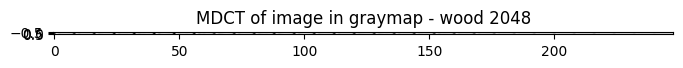

In [23]:
plt.figure()
plt.imshow(im_mdct, cmap='gray')
plt.title(f"MDCT of image in graymap - {image} {size}")

plt.imsave(f'{output}/mdct.png', im_mdct, cmap='gray')

In [24]:
print(im.max(), im.min())
print(im_mdct.max(), im_mdct.min())

121 5
25.48891167456691 -157.13683523043397


In [25]:
for i in range(im_mdct.shape[0]):
    for j in range(0, im_mdct.shape[1], 8):
        im_mdct[i][j:j+8][3:6] = 0

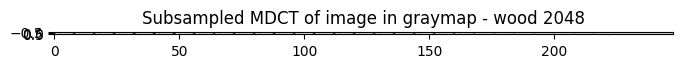

In [26]:
plt.figure()
plt.imshow(im_mdct, cmap='gray')
plt.title(f"Subsampled MDCT of image in graymap - {image} {size}")

plt.imsave(f'{output}/mdct-sub.png', im_mdct, cmap='gray')

In [27]:
im_rec = np.zeros_like(im_hpad, dtype=np.float64)

for i in range(im_mdct.shape[0]):
    for j in range(0, im_mdct.shape[1], 8):
        im_rec[i][j:j+16] += imdct(im_mdct[i][j:j+8]) * wfltr

im_rec = im_rec[:, 8:-8]

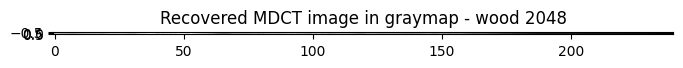

In [28]:
plt.figure()
plt.imshow(im_rec, cmap='gray')
plt.title(f"Recovered MDCT image in graymap - {image} {size}")

plt.imsave(f'{output}/rec.png', im_rec, cmap='gray')

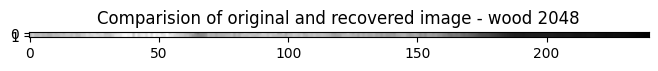

In [29]:
plt.figure()
plt.imshow(np.vstack([im, im_rec]), cmap='gray')
plt.title(f"Comparision of original and recovered image - {image} {size}")

plt.imsave(f'{output}/compare.png', np.vstack([im, im_rec]), cmap='gray')

In [30]:
im_rec

array([[ 88.40131894,  97.64337753,  89.40344267,  88.48089182,
         91.73949831,  86.95373549,  88.52767468,  84.79035381,
         84.46423789,  90.44419858,  89.34819888,  89.14552765,
         94.51068862,  92.93998526,  95.23466339,  94.80868108,
         91.26708059,  97.2816694 ,  90.76982985,  90.16488548,
         97.97348457,  98.79278815, 104.42168639, 101.27872886,
        101.37583985, 104.95073656, 103.57919466, 100.78211949,
        101.56071816,  96.04914618,  96.96591502,  95.01730326,
        100.89395081, 108.74665241, 109.95046553, 109.21468949,
        116.75534396, 118.76421361, 114.30943186, 115.76570925,
         98.5179887 , 114.94015471, 104.43231672, 110.13973345,
        113.21767026, 105.75152653, 115.66817939, 106.02030093,
        119.06657067, 111.12993656, 115.74495125, 110.45137089,
        108.71689749, 117.75970084, 110.16688394, 107.97517526,
        102.12018076, 101.26479278,  97.78972176,  96.18815023,
         91.59871977,  92.52596655,  84.

In [31]:
orig = im.reshape((im.size // 8, 8))

In [32]:
reco = im_rec.astype('int').reshape((im.size // 8, 8))

In [33]:
orig - reco

matrix([[ 0, -1,  1,  2, -1,  1,  2, -1],
        [ 2,  1, -2,  4, -1, -4,  2,  5],
        [ 1, -4, -2,  5,  1,  0,  1, -2],
        [ 5,  1, -7,  4,  6, -3, -3,  4],
        [ 4, -4, -1,  4,  1, -1,  2,  1],
        [-1,  1,  1,  1, -2,  2,  4, -4],
        [-2,  5,  1, -6,  6,  4, -8,  3],
        [ 5, -3,  1,  2,  1, -6,  0, 11],
        [-3, -7,  5,  2, -1,  1,  1,  1],
        [ 0,  0,  1,  3, -3, -2,  3,  1],
        [ 3, -1, -4,  6,  2, -5,  2,  6],
        [-3, -3,  6,  1, -2, -4,  3,  9],
        [-7, -3, 10, -1, -4,  1,  1,  3],
        [ 3, -3, -4,  4,  4,  0, -1,  0],
        [ 2,  0,  0,  1,  1, -3, -1,  5],
        [ 4, -5, -2,  7,  0, -4,  4,  4],
        [-1, -2,  0,  1,  2,  2, -1, -1],
        [ 1,  1,  1,  2, -3, -3,  3,  4],
        [-1, -2,  0,  0,  4,  2, -3,  0],
        [ 2,  0,  1,  2, -2, -1,  2,  0],
        [ 2,  0, -4,  4,  2,  0,  2, -2],
        [-1,  3,  1, -2,  2,  2, -2,  0],
        [ 2,  1,  0,  0,  1,  1,  0,  0],
        [ 1,  1,  0,  0,  1,  1,  

In [34]:
(orig - reco)/orig

matrix([[ 0.        , -0.01041667,  0.01111111,  0.02222222, -0.01111111,
          0.01149425,  0.02222222, -0.01204819],
        [ 0.02325581,  0.01098901, -0.02298851,  0.04301075, -0.01075269,
         -0.04545455,  0.02061856,  0.05050505],
        [ 0.01086957, -0.04301075, -0.02272727,  0.05263158,  0.01020408,
          0.        ,  0.00952381, -0.02020202],
        [ 0.04716981,  0.00952381, -0.07291667,  0.03846154,  0.05607477,
         -0.03225806, -0.03225806,  0.04040404],
        [ 0.03846154, -0.03846154, -0.00925926,  0.03539823,  0.00854701,
         -0.00854701,  0.01724138,  0.00862069],
        [-0.01030928,  0.00869565,  0.00952381,  0.00900901, -0.01801802,
          0.01869159,  0.03361345, -0.03921569],
        [-0.01709402,  0.04310345,  0.00862069, -0.05769231,  0.05263158,
          0.03305785, -0.07843137,  0.02727273],
        [ 0.04672897, -0.03061224,  0.01020408,  0.02040816,  0.01086957,
         -0.06976744,  0.        ,  0.12643678],
        [-0.0428